<a href="https://colab.research.google.com/github/evmpython/imagens_GOES/blob/main/08_imagens_GOES16_estudos_de_caso_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>










## $\underline{Plotando\ Imagem\ de\ Satélite}$
---
**OBJETIVO:** Nesta aula prática aprenderemos como plotar as imagens do canal **visível**, **vapor d'água** e também do **infravermelho**. Para isto usaremos os dados do sensor [Advanced Baseline Imager (ABI)](https://space.oscar.wmo.int/instruments/view/abi) do satélite [Geostationary Operational Environmental Satellite (GOES-16)](https://space.oscar.wmo.int/satellites/view/goes_16).

---


**DADOS DE ENTRADA**: Serão utilizadados os dados da NOAA disponibilizados no repositório da [Amazon](https://noaa-goes16.s3.amazonaws.com/index.html#ABI-L2-CMIPF/) e [CPTEC/INPE](http://ftp.cptec.inpe.br/goes/goes16/retangular)



Exemplo dos dados do CPTEC/INPE:

1. $\underline{Visível}$: CH02 - 0.64 µm
- **Tipo do dado:** matriz de 6262 linhas x 6262 colunas  
- **Formato do dado:** arquivo NETCDF
- **Nome do arquivo:** S10635334_202001231200.nc
- **Fonte dos dados:** FTP do [CPTEC/INPE](http://ftp.cptec.inpe.br/goes/goes16/retangular/ch02/)

    ----------

2. $\underline{Vapor\ d'água}$: CH08 - 6.15 µm
- **Tipo do dado:** matriz de 3131 linhas x 3131 colunas  
- **Formato do dado:** arquivo NETCDF
- **Nome do arquivo:** S10635340_202001231200.nc
- **Fonte dos dados:** FTP do [CPTEC/INPE](http://ftp.cptec.inpe.br/goes/goes16/retangular/ch08/)

    ----------

3. $\underline{Infravermelho}$: CH13 - 10.35 µm
- **Tipo do dado:** matriz de 3131 linhas x 3131 colunas  
- **Formato do dado:** arquivo NETCDF
- **Nome do arquivo:** S10635346_202001231200.nc
- **Fonte dos dados:** FTP do [CPTEC/INPE](http://ftp.cptec.inpe.br/goes/goes16/retangular/ch13/)

---

**DADOS DE SAÍDA:** Figuras de temperatura de brilho e reflectância.
- **Tipo do dado:** Figura
- **Formato do dado:** arquivos PNG e JPG
- **Imagens geradas:**
    1. script_1_2024-04-30_13:00_UTC.png
    2. script_2_2024-04-30_13:00_UTC.png
    3. script_3_2024-04-30_13:00_UTC.png
    4. script_3_animacao_imagens.gif
     

---
**OBSERVAÇÕES IMPORTANTES**:
1. Nenhuma observação.

---
- **Realizado por:** Diego Souza/INPE e Enrique V. Mattos - 19/08/2024
- **Atualizado por:** Enrique V. Mattos - 04/09/2024


---

# **1° Passo:** Instalando bibliotecas




Neste passo instalaremos as bibliotecas necessárias (e suas dependências) para a execução dos scripts. Basicamente, as bibliotecas terão a seguinte finalidade:

*   **Netcdf4 e Xarray:** Ler os dados de arquivos no formato NetCDF
*   **Cartopy:** Adicionar mapas aos plots
*   **Boto3:** Download de dados GOES-16 diretamente da nuvem - Amazon Web Services (AWS)
*   **GDAL:** Reprojeção de imagens GOES-16

In [1]:
# Installing the numpy, netcdf4, boto3 and gdal libraries
!pip install -q "numpy<2.0" xarray cartopy boto3 gdal salem rasterio pyproj geopandas descartes

# **2° Passo:** Download arquivos auxiliares



Neste passo vamos baixar alguns arquivos auxiliares necessários para parte dos scripts que serão demonstrados no curso:

*   **utilities.py:** Script com algumas funções para processamento de dados de satélite
*   **ir.cpt:** Paleta de cores para o canal do infravermelhos do GOES-16

In [2]:
# importa biblioteca que contabiliza o tempo de processamento
import time

# Download do arquivo "utilities.py"
!wget -c https://github.com/evmpython/CAT010_UNIFEI_2024/raw/main/utils/utilities.py

# Download da paleta de cores para o canal do infravermelho
!wget -c https://github.com/evmpython/CAT010_UNIFEI_2024/raw/main/utils/ir.cpt

--2024-09-23 18:18:08--  https://github.com/evmpython/CAT010_UNIFEI_2024/raw/main/utils/utilities.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/evmpython/CAT010_UNIFEI_2024/main/utils/utilities.py [following]
--2024-09-23 18:18:08--  https://raw.githubusercontent.com/evmpython/CAT010_UNIFEI_2024/main/utils/utilities.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2024-09-23 18:18:08--  https://github.com/evmpython/CAT010_UNIFEI_2024/raw/main/utils/ir.cpt
Resolving github.com (github.com)... 140.82.113.3
Connecting to 

# **3° Passo:** Montando drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **4° Passo:** Caminho do diretório - **### >>> MUDANÇAS AQUI <<< ###**
- Insira aqui o caminho da pasta do seu Google Drive onde esta o código dessa aula.

In [4]:
# nome do diretório
dir = '/content/drive/MyDrive/2-PESQUISA/0_GLM/estudos_de_caso/2024-09-23_CCM_RS/'

In [5]:
# cria a pasta de saída com o nome "output"
import os

dir_output = f'{dir}output'

os.makedirs(dir_output, exist_ok=True)

#**Script 01** - Projeção Satélite e Imagem em Níveis de Cinza



Neste primeiro script vamos acessar e processar um arquivo NetCDF do sensor ABI do satélite GOES-16 e visualizar a imagem na projeção original (conhecida como projeção "GOES-R" ou "satélite"). Temos basicamente 5 "blocos" de código:



File /content/input/OR_ABI-L2-CMIPF-M6C13_G16_s20242671310208_e20242671319527_c20242671320001.nc exists


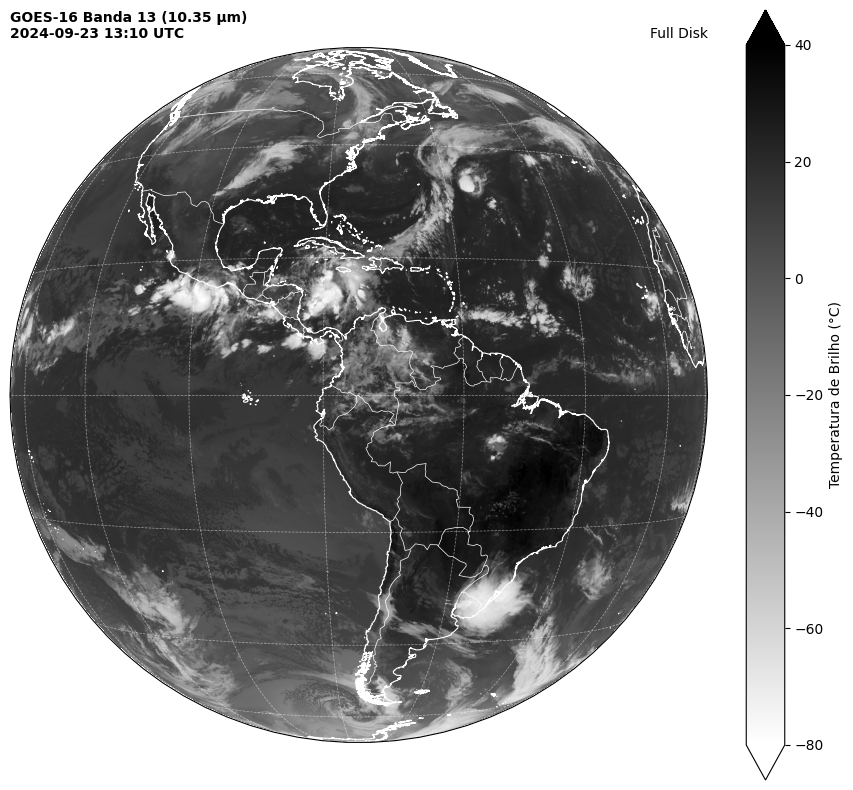

CPU times: user 23.8 s, sys: 1.74 s, total: 25.5 s
Wall time: 34.9 s


In [6]:
%%time
#========================================================================================================================#
#                                          IMPORTAÇÃO DAS BIBLIOTECAS
#========================================================================================================================#
import xarray as xr
import matplotlib.pyplot as plt
import cartopy, cartopy.crs as ccrs
from datetime import datetime
from utilities import download_CMI
import os

#========================================================================================================================#
#                                        CRIA DIRETÓRIO DE ENTRADA E SAÍDA
#========================================================================================================================#
input = "/content/input"; os.makedirs(input, exist_ok=True)
output = dir_output

#========================================================================================================================#
#                                               DOWNLOAD DO ARQUIVO
#========================================================================================================================#
# data de processamento
yyyymmddhhmn = '202409231310'

# canal do ABI
band = '13'

# download do arquivo (CMI: "Cloud and Moisture Imagery" Product)
file_name = download_CMI(yyyymmddhhmn, band, input)

# caminho do arquivo que foi baixado
path = f'{input}/{file_name}.nc'

#========================================================================================================================#
#                                               LEITURA DO ARQUIVO
#========================================================================================================================#
# abre a imagem
data = xr.open_dataset(path)

#========================================================================================================================#
#                                                 PLOTA A IMAGEM
#========================================================================================================================#
# tamanho da figura (largura x altura em polegadas)
plt.figure(figsize=(10,10))

# usa a projeção geoestacionária do cartopy
# para o GOES-16: longitude central: -75.0 / altura do satellite: 35786023.0
# a extensão do Full Disk: (metade dos pixels full disk) X (tamanho do pixel em radianos) X (altura do satélite em metros) => 2712 * 0.000056 * 35786023.0 = 5434894.67527
ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))
img_extent = (-5434894.67527, 5434894.67527, -5434894.67527, 5434894.67527)

# linhas costeiras, bordas e linhas de grade do mapa
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
ax.gridlines(color='white', alpha=0.5, linestyle='--', linewidth=0.5)

# escala de cores
colormap = "gray_r" # escala de cores na ordem reversa - branco para preto para o canal do IR

# plota imagem
img = ax.imshow(data['CMI'] - 273.15, origin='upper', vmin=-80, vmax=40, extent=img_extent, cmap=colormap)

# barra de cores
plt.colorbar(img, label='Temperatura de Brilho (°C)', extend='both', orientation='vertical', pad=0.05, fraction=0.05)

# leitura da data/horário do arquivo NetCDF como uma string
date = (datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')).strftime('%Y-%m-%d %H:%M UTC')

# título da figura
plt.title(f'GOES-16 Banda 13 (10.35 µm)\n{date}', fontweight='bold', fontsize=10, loc='left')
plt.title('Full Disk', fontsize=10, loc='right')

# salva figura
plt.savefig(f'{output}/script_1_{date.replace(" ", "_")}.png')

# mostra figura na tela
plt.show()

#**Script 02** - Projeção Satélite e Imagem Realçada

File /content/input/OR_ABI-L2-CMIPF-M6C13_G16_s20242671310208_e20242671319527_c20242671320001.nc exists


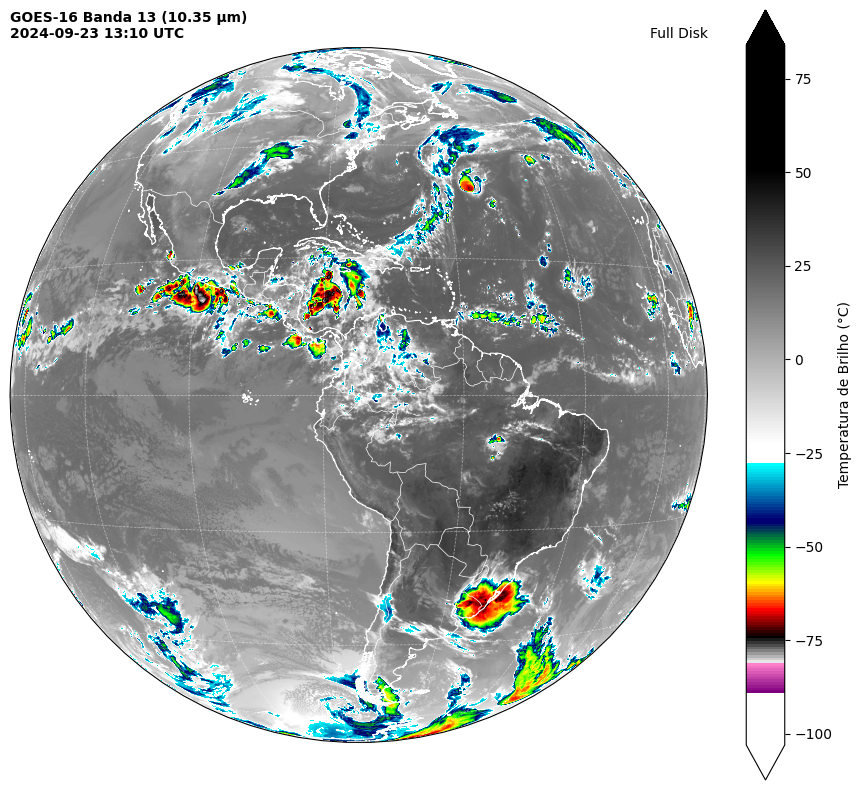

CPU times: user 8.3 s, sys: 1.27 s, total: 9.57 s
Wall time: 9.35 s


In [7]:
%%time
#========================================================================================================================#
#                                          IMPORTAÇÃO DAS BIBLIOTECAS
#========================================================================================================================#
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy, cartopy.crs as ccrs
from datetime import datetime
from utilities import download_CMI, remap, loadCPT
import os

#========================================================================================================================#
#                                        CRIA DIRETÓRIO DE ENTRADA E SAÍDA
#========================================================================================================================#
input = "/content/input"; os.makedirs(input, exist_ok=True)
output = dir_output

#========================================================================================================================#
#                                               DOWNLOAD DO ARQUIVO
#========================================================================================================================#
# data de processamento
yyyymmddhhmn = '202409231310'

# canal do ABI
band = '13'

# download do arquivo (CMI: "Cloud and Moisture Imagery" Product)
file_name = download_CMI(yyyymmddhhmn, band, input)

# caminho do arquivo que foi baixado
path = f'{input}/{file_name}.nc'

#========================================================================================================================#
#                                               LEITURA DO ARQUIVO
#========================================================================================================================#
# abre a imagem
data = xr.open_dataset(path)

#========================================================================================================================#
#                                                 PLOTA A IMAGEM
#========================================================================================================================#
# tamanho da figura (largura x altura em polegadas)
plt.figure(figsize=(10,10))

# usa a projeção geoestacionária do cartopy
# para o GOES-16: longitude central: -75.0 / altura do satellite: 35786023.0
# a extensão do Full Disk: (metade dos pixels full disk) X (tamanho do pixel em radianos) X (altura do satélite em metros) => 2712 * 0.000056 * 35786023.0 = 5434894.67527
ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))
img_extent = (-5434894.67527, 5434894.67527, -5434894.67527, 5434894.67527)

# linhas costeiras, bordas e linhas de grade do mapa
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
ax.gridlines(color='white', alpha=0.5, linestyle='--', linewidth=0.5)

# converte o arquivo CPT para ser usado em Python
cpt = loadCPT('ir.cpt')
colormap = cm.colors.LinearSegmentedColormap('cpt', cpt)

# plota imagem
img = ax.imshow(data['CMI'] - 273.15, origin='upper', vmin=-103.0, vmax=84, extent=img_extent, cmap=colormap)

# barra de cores
plt.colorbar(img, label='Temperatura de Brilho (°C)', extend='both', orientation='vertical', pad=0.05, fraction=0.05)

# leitura da data/horário do arquivo NetCDF como uma string
date = (datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')).strftime('%Y-%m-%d %H:%M UTC')

# título da figura
plt.title(f'GOES-16 Banda 13 (10.35 µm)\n{date}', fontweight='bold', fontsize=10, loc='left')
plt.title('Full Disk', fontsize=10, loc='right')

# salva figura
plt.savefig(f'{output}/script_2_{date.replace(" ", "_")}.png')

# mostra figura na tela
plt.show()

#**Script 03** - Projeção Retangular + Relâmpagos

In [ ]:
#========================================================================================================================#
#                                               REQUIRED MODULES
#========================================================================================================================#
import xarray as xr                                              # Work with multidimensional arrays
import matplotlib.pyplot as plt                                  # Plotting library
from matplotlib import cm                                        # Colormap handling utilities
import cartopy, cartopy.crs as ccrs                              # Plot maps
import cartopy.io.shapereader as shpreader                       # Read shapefiles
from datetime import timedelta, datetime                         # Basic Dates and time types
from utilities import download_CMI, download_GLM, remap, loadCPT # Our own utilities
import numpy as np                                               # Scientific computing with Python
import os                                                        # Miscellaneous operating system interfaces
import pandas as pd                                              # Work with dataframes
import geopandas as gpd                                          # Work with geodataframes
import salem                                                     # Work with shapefiles
import imageio
import glob

#========================================================================================================================#
#                                             INITIAL DEFINITIONS
#========================================================================================================================#
# Create the input and output directories
input = "/content/samples"; os.makedirs(input, exist_ok=True)
output = dir_output

# Channel
band = '13'

# Reading Santa Maria shapefile
santa_maria = salem.read_shapefile('https://github.com/evmpython/minicurso_nowcasting_CPAM2024/raw/main/shapefiles/SANTA_MARIA_MUN.shp')

# Desired extent
lonmin, lonmax, latmin, latmax = -60.0, -35., -40., -25.
extent = [lonmin, latmin, lonmax, latmax] # min lon, max lon, min lat, max lat

#========================================================================================================================#
#                                              LOOP OF IMAGES
#========================================================================================================================#
# Images Loop
time_images = []
for date_image in pd.date_range('202409231300', '202409231500', freq='10min'):

    #--------------------------------------------------------------------------#
    #                          TIME AND DATE
    #--------------------------------------------------------------------------#
    # Datetime to process
    yyyymmddhhmn = date_image.strftime('%Y%m%d%H%M') # '202404301300'

    # Time and data references
    yyyy = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%Y')
    mm = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%m')
    dd = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%d')
    hh = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%H')
    mn = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%M')
    time_images.append(f'{hh}:{mn}')

    print('#=====================================================================================================#')
    print(f'                           PROCESSING THE IMAGE = {yyyy}-{mm}-{dd} {hh}{mn} UTC'                       )
    print('#=====================================================================================================#')

    # Download the file
    file_name = download_CMI(yyyymmddhhmn, band, input)

    # Path of the downloaded file
    path = f'{input}/{file_name}.nc'

    #--------------------------------------------------------------------------#
    #                    REPROJECT AND READ THE ABI DATA
    #--------------------------------------------------------------------------#

    # Call the reprojection funcion (file, variable, extent, resolution)
    grid = remap(path, 'CMI', extent, 2)

    # Read the data returned by the function and convert to °C
    data = grid.ReadAsArray() - 273.15

    #--------------------------------------------------------------------------#
    #                           GET THE GLM DATA
    #--------------------------------------------------------------------------#
    # Date of the current image and next image
    date_ini = str(datetime(int(yyyy),int(mm),int(dd),int(hh),int(mn)))
    date_end = str(datetime(int(yyyy),int(mm),int(dd),int(hh),int(mn)) + timedelta(minutes=10))
    date_loop = date_ini

    # GLM accumulation loop
    lats_flash, lons_flash = np.array([]), np.array([])
    while (date_loop <= date_end):

        # Date structure
        yyyymmddhhmnss = datetime.strptime(date_loop, '%Y-%m-%d %H:%M:%S').strftime('%Y%m%d%H%M%S')

        # Download the file
        file_glm = download_GLM(yyyymmddhhmnss, input)

        # Read the file
        glm_20s = xr.open_dataset(f'{input}/{file_glm}.nc')

        # Append lats / longs
        lats_flash = np.append(lats_flash, glm_20s['flash_lat'][:])
        lons_flash = np.append(lons_flash, glm_20s['flash_lon'][:])

        # Close the file
        glm_20s.close()

        # Increment the date_loop
        date_loop = str(datetime.strptime(date_loop, '%Y-%m-%d %H:%M:%S') + timedelta(seconds=20))
    #--------------------------------------------------------------------------#

    # Select the flashes inside the region
    # Put the flashes into dataframe
    data_flash = {'lat': lats_flash, 'lon': lons_flash}
    df = pd.DataFrame(data_flash)

    # Select the flashes from region of interest
    df_flash_filtered = df[ (df['lon'] > lonmin) & (df['lon'] < lonmax) & (df['lat'] > latmin) & (df['lat'] < latmax)]

    # Transform from dataframe to array
    lons_flash_filtered, lats_flash_filtered = df_flash_filtered['lon'].values, df_flash_filtered['lat'].values

    #--------------------------------------------------------------------------#
    #                           PLOT THE IMAGE
    #--------------------------------------------------------------------------#
    # Choose the plot size (width x height, in inches)
    plt.figure(figsize=(14,11))

    # Use the Geostationary projection in cartopy
    ax = plt.axes(projection=ccrs.PlateCarree())

    # linhas costeiras, bordas e linhas de grade do mapa
    #ax.coastlines(resolution='10m', color='white', linewidth=0.8)
    #ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
    #ax.gridlines(color='white', alpha=0.5, linestyle='--', linewidth=0.5)

    # Converts a CPT file to be used in Python
    cpt = loadCPT('ir.cpt')
    cmap = cm.colors.LinearSegmentedColormap('cpt', cpt)

    # Plot the image
    img = ax.imshow(data, origin='upper', vmin=-103.0, vmax=84, extent=[lonmin, lonmax, latmin, latmax], cmap=cmap, alpha=1.0)

    # Plot the GLM Data
    glm = plt.scatter(lons_flash_filtered, lats_flash_filtered, transform=ccrs.PlateCarree(), marker='o', s=30, facecolor='white', edgecolor='black', linewidth=1, alpha=0.8, zorder=2, label=f'Flashes={str(len(lats_flash_filtered)).zfill(4)}')

    # Add legend
    ax.legend(loc='lower right', ncols=1, facecolor='white', frameon=True)

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    # Plot States shapefile
    shapefile = list(shpreader.Reader('https://github.com/evmpython/minicurso_nowcasting_CPAM2024/raw/main/shapefiles/BR_UF_2019.shp').geometries())
    ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='white', facecolor='none', linewidth=1.0)

    # Plot Santa Maria shapefile
    #shapefile = list(shpreader.Reader('https://github.com/evmpython/minicurso_nowcasting_CPAM2024/raw/main/shapefiles/SANTA_MARIA_MUN.shp').geometries())
    #ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='gray', facecolor='none', linewidth=3.0, zorder=3)

    # Add a colorbar
    plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0.05)

    # Read the time/date from the NetCDF file metadata as a string
    date = (datetime.strptime(xr.open_dataset(path).time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')).strftime('%Y-%m-%d %H:%M UTC')

    # Add a title
    plt.title(f'GOES-16 Band 13 (10.3 µm) + GLM Flashes\nABI: {date}', fontweight='bold', fontsize=10, loc='left')
    plt.title(f'GLM: {str(date_ini)} - {str(date_end)}', fontsize="10", loc="right")

    # Save the image
    plt.savefig(f'{output}/script_3_{yyyy}-{mm}-{dd}_{hh}:{mn}_UTC.png', bbox_inches='tight', dpi=300)

    # Show the image (uncomment this to show each image)
    #plt.show()

#=====================================================================================================#
                           PROCESSING THE IMAGE = 2024-09-23 1300 UTC
#=====================================================================================================#
File /content/samples/OR_ABI-L2-CMIPF-M6C13_G16_s20242671300208_e20242671309527_c20242671310011.nc exists
Remapping...
Remap finished! Time: 0.41 seconds
File /content/samples/OR_GLM-L2-LCFA_G16_s20242671300000_e20242671300200_c20242671300212.nc exists
File /content/samples/OR_GLM-L2-LCFA_G16_s20242671300200_e20242671300400_c20242671300414.nc exists
File /content/samples/OR_GLM-L2-LCFA_G16_s20242671300400_e20242671301000_c20242671301017.nc exists
File /content/samples/OR_GLM-L2-LCFA_G16_s20242671301000_e20242671301200_c20242671301214.nc exists
File /content/samples/OR_GLM-L2-LCFA_G16_s20242671301200_e20242671301400_c20242671301415.nc exists
File /content/samples/OR_GLM-L2-LCFA_G16_s20242671301400_e20242671302000_

Produz animação

In [ ]:
# monta lista dos arquivos
files = sorted(glob.glob(f'{dir_output}script_3_*.jpg'))

# cria uma lista com as imagens
images = []
for file in files:
    images.append(imageio.imread(file))

# salva em formato de animação de imagens
imageio.mimsave(f'{dir_output}script_3_animacao_imagens.gif',
                images,
                duration=500,
                loop=0)

# mostrando a animação na tela
print("\nAbrindo o GIF..\n")

from IPython.display import Image

Image(open(f'{dir_output}script_3_animacao_imagens.gif','rb').read(), width=600)